### (SPP) Shortest Path Problem
- Find the shortest path from a specified node $s\in N$ to another node $t\in N$
- Sets:
    - $N$: set of nodes
    - $A$: set of arcs
- Parameters:
    - $c_{ij}$: cost of traversing arc $(i,j)\in A$
- Decision variables:
    - $X_{(i,j)}=1$, if arc $(i,j)$ is on the shortest path from node $s\in N$ to node $t\in N$; or 0, O.W.

<br>

$$
\begin{split}
\text{(SPP)}\quad & \text{minimize}\quad \sum\limits_{i\in I}\sum\limits_{j\in J}c_{ij}X_{ij}\\
&\begin{split}
\text{subject to}\quad\quad \sum\limits_{j\in B_i}&X_{(j,i)}-\sum\limits_{j\in A_i}X_{(i,k)}=\begin{cases}-1 \text{ }&\text{if node }i=s\\0 &i\in N,i\ne s,i\ne t\\1 &\text{if node }i=t\end{cases} \quad\quad&\forall i\in N\\
        &X_{ij}\in \{0,1\} \quad\quad\forall (i,j)\in A\\ 
\end{split}
\end{split}
$$

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from statistics import mean
from gurobipy import Model, GRB, quicksum
%matplotlib inline

In [2]:
# settings
sns.reset_orig
sns.set_style('darkgrid')
sns.set_palette('Set1')

np.set_printoptions(linewidth=200)

In [3]:
# import data
points = pd.read_excel('data.xlsx', sheet_name='points')
links = pd.read_excel('data.xlsx', sheet_name='links')

In [4]:
# declare the parameters and sets
N = [tuple(v) for v in points.values]
I = [i for i in range(len(N))]

A = [(i,j) for i in I for j in I]

c = {(i,j): links['Cost'].sum() + 1 for i,j in A}
c.update({
    (row['P1'], row['P2']): row['Cost'] 
    for index, row in links.iterrows()
})

s = 0
t = len(N) - 1
print(N[s],'->',N[t])

(0.0, 0.0) -> (2.0, 2.0)


In [5]:
# create model
mdl = Model('SPP')

Academic license - for non-commercial use only - expires 2022-08-28
Using license file C:\Users\jack4\gurobi.lic


In [6]:
# add model variables
X = mdl.addVars(A, vtype=GRB.BINARY)

In [7]:
# add objective function
mdl.ModelSense = GRB.MINIMIZE
mdl.setObjective(quicksum(c[i,j]*X[i,j] for i,j in A))

In [8]:
# add the model constraints
mdl.addConstrs(
    quicksum(X[j[0],i] for j in A if j[1] == i) 
    - quicksum(X[i,k[1]] for k in A if k[0] == i) 
    == -1 
    for i in I if i == s
)
mdl.addConstrs(
    quicksum(X[j[0],i] for j in A if j[1] == i) 
    - quicksum(X[i,k[1]] for k in A if k[0] == i) 
    == 0 
    for i in I if s != i != t
)
mdl.addConstrs(
    quicksum(X[j[0],i] for j in A if j[1] == i) 
    - quicksum(X[i,k[1]] for k in A if k[0] == i) 
    == 1 
    for i in I if i == t
)
mdl.update()

In [9]:
%%time

# optimize
mdl.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 13 rows, 169 columns and 312 nonzeros
Model fingerprint: 0x7c658640
Variable types: 0 continuous, 169 integer (169 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 535.0000000
Presolve removed 0 rows and 13 columns
Presolve time: 0.01s
Presolved: 13 rows, 156 columns, 312 nonzeros
Variable types: 0 continuous, 156 integer (156 binary)

Root relaxation: objective 3.000000e+01, 10 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      30.0000000   30.00000  0.00%     -    0s

Explored 1 nodes (10 simplex iterations) in 0.04 second

In [10]:
# get the route
route = {(i,j): c[i,j] for i,j in A if X[i,j].X > 0}
route

{(0, 1): 9, (1, 4): 5, (4, 7): 4, (7, 12): 12}

Text(0.5, 1.0, 'Shortest Path')

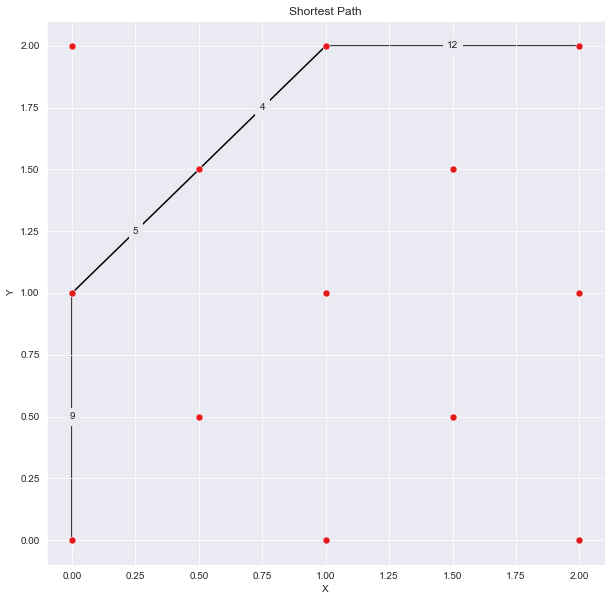

In [11]:
# plot the coverage
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='X', y='Y', data=points, s=50, legend=False, label="Locations")

for path, nb in route.items():
    point1 = N[path[0]]
    point2 = N[path[1]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    
    plt.plot(x_values, y_values, 'k', linestyle="-", zorder=0)
    plt.text(
        mean(x_values), mean(y_values), nb, backgroundcolor='#eaeaf2',
        horizontalalignment='center', verticalalignment='center'
    )

plt.title('Shortest Path')

In [12]:
# find objective value
print('Objective value =', sum(c[a]*X[a].X for a in A))

Objective value = 30.0
